In [1]:
!pip install matplotlib numpy torchvision tqdm


=== Training Task 1 ===


100%|██████████| 396/396 [00:00<00:00, 577.28it/s]


Epoch 1, Loss: 0.4965


100%|██████████| 396/396 [00:00<00:00, 488.50it/s]


Epoch 2, Loss: 0.2465
Accuracy on Task 1: 0.998

=== Training Task 2 ===


100%|██████████| 378/378 [00:09<00:00, 40.27it/s]


Epoch 1, Loss: 0.6049


100%|██████████| 378/378 [00:08<00:00, 45.07it/s]


Epoch 2, Loss: 0.4103
Accuracy on Task 1: 0.996
Accuracy on Task 2: 0.873

=== Training Task 3 ===


100%|██████████| 352/352 [00:07<00:00, 45.41it/s]


Epoch 1, Loss: 0.5626


100%|██████████| 352/352 [00:07<00:00, 45.14it/s]


Epoch 2, Loss: 0.4746
Accuracy on Task 1: 0.992
Accuracy on Task 2: 0.862
Accuracy on Task 3: 0.819

=== Training Task 4 ===


100%|██████████| 381/381 [00:08<00:00, 45.42it/s]


Epoch 1, Loss: 0.4968


100%|██████████| 381/381 [00:08<00:00, 45.23it/s]


Epoch 2, Loss: 0.3122
Accuracy on Task 1: 0.982
Accuracy on Task 2: 0.850
Accuracy on Task 3: 0.812
Accuracy on Task 4: 0.964

=== Training Task 5 ===


100%|██████████| 369/369 [00:08<00:00, 44.97it/s]


Epoch 1, Loss: 0.7446


100%|██████████| 369/369 [00:08<00:00, 45.37it/s]


Epoch 2, Loss: 0.5025
Accuracy on Task 1: 0.944
Accuracy on Task 2: 0.770
Accuracy on Task 3: 0.462
Accuracy on Task 4: 0.957
Accuracy on Task 5: 0.834
=== Continual Learning Metrics ===
Average Accuracy (ACC):       0.7935
Forgetting (F):              0.1301
Backward Transfer (BWT):     -0.1301
Forward Transfer (FWT):      0.0000
Memory Usage:                153.71 MB
Computation Cost:            200 projections/batch
Plasticity-Stability Measure (PSM): 0.4350 (0-1 normalized)
=== Metrics (Split MNIST) ===
ACC=0.7935, F=0.1301, BWT=-0.1301, FWT=0.0000, Mem=153.71MB, PSM=0.4350


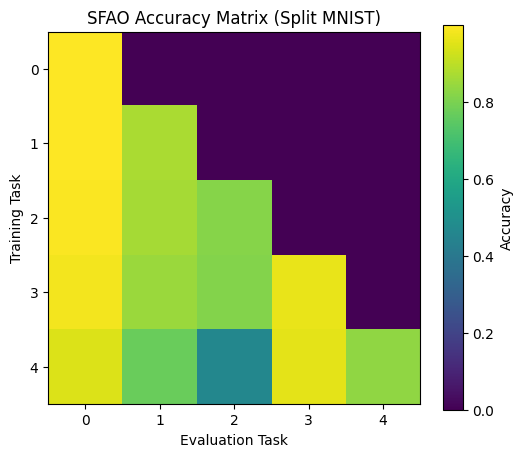

In [4]:
# Selective Forgetting-Aware Optimization (SFAO) on Split MNIST
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import random  # for monte carlo sampling

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Simple MLP model
class SimpleMLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, output_size=2):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.net(x.view(x.size(0), -1))


# SFAO Implementation (Updated Methods Only)
class SFAO:
    def __init__(self, model, lr=0.001, device='cuda',
                 max_memory=200, cosine_threshold=0.80, discard_threshold=-1e-4, sample_size=750):
        self.model = model.to(device)
        self.lr = lr
        self.device = device
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.S = []  # stored gradient vectors
        self.max_memory = max_memory
        self.cosine_threshold = cosine_threshold
        self.discard_threshold = discard_threshold
        self.sample_size = sample_size

    # flatten gradient
    def _flatten_grad(self):
        return torch.cat([p.grad.view(-1) for p in self.model.parameters() if p.grad is not None])

    # assign gradient
    def _assign_grad(self, flat_grad):
        idx = 0
        for p in self.model.parameters():
            if p.grad is not None:
                numel = p.numel()
                p.grad.copy_(flat_grad[idx:idx+numel].view_as(p))
                idx += numel

    # project new gradient against memory
    def _project_grad(self, g):
        if len(self.S) == 0: return g
        # sample some stored gradients
        sampled = self.S if len(self.S)<=self.sample_size else [self.S[i] for i in torch.randperm(len(self.S))[:self.sample_size]]
        max_cos = 0.0
        for v in sampled:
            cos_sim = torch.dot(g, v)/(torch.norm(g)*torch.norm(v)+1e-12)
            max_cos = max(max_cos, abs(cos_sim.item()))
           #max_cos = max(max_cos, cos_sim.item())
        if max_cos > self.cosine_threshold:
            return g  # do not project
        if max_cos < self.discard_threshold:
            return None
        g_proj = g.clone()
        for v in sampled:
            proj = (torch.dot(g_proj, v)/torch.dot(v,v))*v
            g_proj -= proj
        # discard tiny projected gradients
        if torch.norm(g_proj) < self.discard_threshold:
            return None
        return g_proj

    # one training step
    def observe(self, x, y, criterion=nn.CrossEntropyLoss()):
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)
        self.optimizer.zero_grad()
        loss = criterion(self.model(x), y)
        loss.backward()

        g = self._flatten_grad()
        g_proj = self._project_grad(g)
        if g_proj is not None:
            self._assign_grad(g_proj)
            self.optimizer.step()
        return loss.item()

    # store task gradients
    def end_task(self, dataloader, criterion=nn.CrossEntropyLoss()):
        self.model.eval()
        for x, y in dataloader:
            x, y = x.to(self.device), y.to(self.device)
            self.model.zero_grad()
            loss = criterion(self.model(x), y)
            loss.backward()
            g = self._flatten_grad()
            norm_g = g / (torch.norm(g)+1e-10)
            if len(self.S) >= self.max_memory:
                self.S.pop(0)
            self.S.append(norm_g.detach().clone())


# Prepare Split MNIST (5 tasks, 2 classes each)
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

def split_dataset(dataset, classes):
    idx = np.isin(dataset.targets.numpy(), classes)
    data = dataset.data[idx].float()/255.0
    targets = dataset.targets[idx]
    mapping = {cls:i for i,cls in enumerate(classes)}
    targets = torch.tensor([mapping[t.item()] for t in targets])
    return TensorDataset(data.view(-1, 28*28), targets)

task_classes = [[0,1],[2,3],[4,5],[6,7],[8,9]]
train_tasks = [split_dataset(mnist_train, c) for c in task_classes]
test_tasks = [split_dataset(mnist_test, c) for c in task_classes]

# Training with Metrics
num_tasks = len(train_tasks)
num_epochs = 2
batch_size = 32

model = SimpleMLP(input_size=784, hidden_size=256, output_size=2)
sfao = SFAO(model, lr=0.001, device=device)  

accuracy_matrix = np.zeros((num_tasks, num_tasks))

def evaluate_task(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

for task_id, train_dataset in enumerate(train_tasks):
    print(f"\n=== Training Task {task_id+1} ===")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Train
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x, y in tqdm(train_loader):
            loss = sfao.observe(x, y)  # Changed from ogd.observe
            epoch_loss += loss
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Evaluate on all tasks seen so far
    for eval_id in range(task_id+1):
        test_loader = DataLoader(test_tasks[eval_id], batch_size=batch_size, shuffle=False)
        acc = evaluate_task(sfao.model, test_loader)  # Changed from ogd.model
        accuracy_matrix[task_id, eval_id] = acc
        print(f"Accuracy on Task {eval_id+1}: {acc:.3f}")

    # End of task: store gradient directions
    sfao.end_task(train_loader)  # Changed from ogd.end_task


# Compute Continual Learning Metrics
# Average Accuracy (ACC)
ACC = accuracy_matrix[-1].mean()  # Final row averaged across tasks

# Average Forgetting (F)
F = np.mean([
    np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j]
    for j in range(num_tasks-1)
])

# Backward Transfer (BWT)
BWT = np.mean([
    accuracy_matrix[-1, j] - accuracy_matrix[j, j]
    for j in range(num_tasks-1)
])

# Forward Transfer (FWT)
# Measures how much previous tasks helped the next task before it was trained
FWT = np.mean([
    accuracy_matrix[i, i+1]
    for i in range(num_tasks-1)
])

# Memory Usage (in MB)
num_params = sum(p.numel() for p in sfao.model.parameters())
mem_usage = len(sfao.S) * num_params * 4 / (1024**2)  # 4 bytes per float32

# 6. Computation Cost (Number of gradient projections per batch)
comp_cost = len(sfao.S)

# Plasticity-Stability Measure (PSM) - Normalized 0 to 1

# Define components
stability = 1 - F                 # High if forgetting is low
plasticity = max(FWT, 0)          # High if positive forward transfer

alpha = 0.5                       # Balance between stability and plasticity
PSM = alpha * stability + (1 - alpha) * plasticity

# Print Metrics
print("=== Continual Learning Metrics ===")
print(f"Average Accuracy (ACC):       {ACC:.4f}")
print(f"Forgetting (F):              {F:.4f}")
print(f"Backward Transfer (BWT):     {BWT:.4f}")
print(f"Forward Transfer (FWT):      {FWT:.4f}")
print(f"Memory Usage:                {mem_usage:.2f} MB")
print(f"Computation Cost:            {comp_cost} projections/batch")
print(f"Plasticity-Stability Measure (PSM): {PSM:.4f} (0-1 normalized)")

print("=== Metrics (Split MNIST) ===")
print(f"ACC={ACC:.4f}, F={F:.4f}, BWT={BWT:.4f}, FWT={FWT:.4f}, Mem={mem_usage:.2f}MB, PSM={PSM:.4f}")

plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('SFAO Accuracy Matrix (Split MNIST)')
plt.show()


=== Training Task 1 ===


100%|██████████| 1875/1875 [00:03<00:00, 514.40it/s]


Epoch 1, Loss: 2.1141


100%|██████████| 1875/1875 [00:03<00:00, 511.66it/s]


Epoch 2, Loss: 1.5748
Accuracy on Task 1: 0.782

=== Training Task 2 ===


100%|██████████| 1875/1875 [00:43<00:00, 43.59it/s]


Epoch 1, Loss: 1.8241


100%|██████████| 1875/1875 [01:57<00:00, 16.02it/s]


Epoch 2, Loss: 1.1764
Accuracy on Task 1: 0.774
Accuracy on Task 2: 0.819

=== Training Task 3 ===


100%|██████████| 1875/1875 [02:53<00:00, 10.82it/s]


Epoch 1, Loss: 1.6471


100%|██████████| 1875/1875 [02:51<00:00, 10.92it/s]


Epoch 2, Loss: 1.0038
Accuracy on Task 1: 0.719
Accuracy on Task 2: 0.798
Accuracy on Task 3: 0.827
=== Metrics (Permuted MNIST) ===
ACC=0.7815, F=0.0417, BWT=-0.0417, FWT=0.0000, Mem=155.28MB, PSM=0.4791


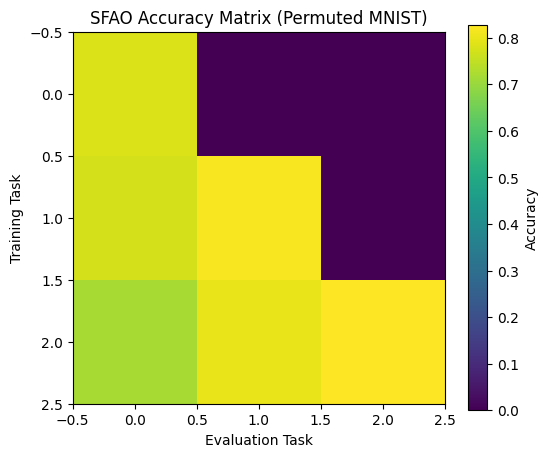

In [8]:
# =======================
# SFAO on Permuted  MNIST
# =======================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import random


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Simple MLP model
class SimpleMLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, output_size=10):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    def forward(self, x):
        return self.net(x.view(x.size(0), -1))

# SFAO Implementation (Updated Methods Only)
class SFAO:
    def __init__(self, model, lr=0.001, device='cuda',
                 max_memory=200, cosine_threshold=0.80, discard_threshold=-1e-4, sample_size=750):
        self.model = model.to(device)
        self.lr = lr
        self.device = device
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.S = []  # stored gradient vectors
        self.max_memory = max_memory
        self.cosine_threshold = cosine_threshold
        self.discard_threshold = discard_threshold
        self.sample_size = sample_size

    # flatten gradient
    def _flatten_grad(self):
        return torch.cat([p.grad.view(-1) for p in self.model.parameters() if p.grad is not None])

    # assign gradient
    def _assign_grad(self, flat_grad):
        idx = 0
        for p in self.model.parameters():
            if p.grad is not None:
                numel = p.numel()
                p.grad.copy_(flat_grad[idx:idx+numel].view_as(p))
                idx += numel

    # project new gradient against memory
    def _project_grad(self, g):
        if len(self.S) == 0: return g
        # sample some stored gradients
        sampled = self.S if len(self.S)<=self.sample_size else [self.S[i] for i in torch.randperm(len(self.S))[:self.sample_size]]
        max_cos = 0.0
        for v in sampled:
            cos_sim = torch.dot(g, v)/(torch.norm(g)*torch.norm(v)+1e-12)
            max_cos = max(max_cos, abs(cos_sim.item()))
           #max_cos = max(max_cos, cos_sim.item())
        if max_cos > self.cosine_threshold:
            return g  # do not project
        if max_cos < self.discard_threshold:
            return None
        g_proj = g.clone()
        for v in sampled:
            proj = (torch.dot(g_proj, v)/torch.dot(v,v))*v
            g_proj -= proj
        # discard tiny projected gradients
        if torch.norm(g_proj) < self.discard_threshold:
            return None
        return g_proj

    # one training step
    def observe(self, x, y, criterion=nn.CrossEntropyLoss()):
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)
        self.optimizer.zero_grad()
        loss = criterion(self.model(x), y)
        loss.backward()

        g = self._flatten_grad()
        g_proj = self._project_grad(g)
        if g_proj is not None:
            self._assign_grad(g_proj)
            self.optimizer.step()
        return loss.item()

    # store task gradients
    def end_task(self, dataloader, criterion=nn.CrossEntropyLoss()):
        self.model.eval()
        for x, y in dataloader:
            x, y = x.to(self.device), y.to(self.device)
            self.model.zero_grad()
            loss = criterion(self.model(x), y)
            loss.backward()
            g = self._flatten_grad()
            norm_g = g / (torch.norm(g)+1e-10)
            if len(self.S) >= self.max_memory:
                self.S.pop(0)
            self.S.append(norm_g.detach().clone())

# === Prepare 3 permuted MNIST tasks ===
num_tasks = 3
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_x = mnist_train.data.view(-1, 28*28).float()/255.0
test_x = mnist_test.data.view(-1, 28*28).float()/255.0
train_y = mnist_train.targets
test_y = mnist_test.targets

train_tasks, test_tasks = [], []
for _ in range(num_tasks):
    perm = torch.randperm(28*28)
    train_tasks.append(TensorDataset(train_x[:, perm], train_y))
    test_tasks.append(TensorDataset(test_x[:, perm], test_y))


# Training loop
num_epochs = 2
batch_size = 32
model = SimpleMLP()
sfao = SFAO(model, lr=0.001, device=device)
accuracy_matrix = np.zeros((num_tasks, num_tasks))

def evaluate_task(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

for task_id, train_dataset in enumerate(train_tasks):
    print(f"\n=== Training Task {task_id+1} ===")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x, y in tqdm(train_loader):
            epoch_loss += sfao.observe(x, y)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Evaluate on all seen tasks
    for eval_id in range(task_id+1):
        test_loader = DataLoader(test_tasks[eval_id], batch_size=batch_size, shuffle=False)
        acc = evaluate_task(sfao.model, test_loader)
        accuracy_matrix[task_id, eval_id] = acc
        print(f"Accuracy on Task {eval_id+1}: {acc:.3f}")

    sfao.end_task(train_loader)

# === Metrics ===
ACC = accuracy_matrix[-1].mean()
F = np.mean([np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j] for j in range(num_tasks-1)]) if num_tasks>1 else 0.0
BWT = np.mean([accuracy_matrix[-1, j] - accuracy_matrix[j, j] for j in range(num_tasks-1)]) if num_tasks>1 else 0.0
FWT = np.mean([accuracy_matrix[i, i+1] for i in range(num_tasks-1)]) if num_tasks>1 else 0.0

num_params = sum(p.numel() for p in sfao.model.parameters())
mem_usage = len(sfao.S) * num_params * 4 / (1024**2)
comp_cost = len(sfao.S)
PSM = 0.5*(1-F) + 0.5*max(FWT,0)

print("=== Metrics (Permuted MNIST) ===")
print(f"ACC={ACC:.4f}, F={F:.4f}, BWT={BWT:.4f}, FWT={FWT:.4f}, Mem={mem_usage:.2f}MB, PSM={PSM:.4f}")

plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('SFAO Accuracy Matrix (Permuted MNIST)')
plt.show()

Files already downloaded and verified
Files already downloaded and verified
Task 0: classes 0-9, train=5000, test=1000
Task 1: classes 10-19, train=5000, test=1000
Task 2: classes 20-29, train=5000, test=1000
Task 3: classes 30-39, train=5000, test=1000
Task 4: classes 40-49, train=5000, test=1000
Task 5: classes 50-59, train=5000, test=1000
Task 6: classes 60-69, train=5000, test=1000
Task 7: classes 70-79, train=5000, test=1000
Task 8: classes 80-89, train=5000, test=1000
Task 9: classes 90-99, train=5000, test=1000
Prepared 10 tasks (mode=split)

=== Training Task 1 ===


100%|██████████| 209/209 [00:00<00:00, 273.63it/s]


Epoch 1, Loss=2.2914


100%|██████████| 209/209 [00:00<00:00, 232.88it/s]


Epoch 2, Loss=2.2649
Accuracy on Task 1: 0.239

=== Training Task 2 ===


100%|██████████| 209/209 [00:06<00:00, 34.08it/s]


Epoch 1, Loss=2.2943


100%|██████████| 209/209 [00:06<00:00, 34.33it/s]


Epoch 2, Loss=2.2800
Accuracy on Task 1: 0.232
Accuracy on Task 2: 0.169

=== Training Task 3 ===


100%|██████████| 209/209 [00:06<00:00, 34.15it/s]


Epoch 1, Loss=2.2827


100%|██████████| 209/209 [00:06<00:00, 32.59it/s]


Epoch 2, Loss=2.2482
Accuracy on Task 1: 0.185
Accuracy on Task 2: 0.166
Accuracy on Task 3: 0.176

=== Training Task 4 ===


100%|██████████| 209/209 [00:06<00:00, 34.15it/s]


Epoch 1, Loss=2.2972


100%|██████████| 209/209 [00:06<00:00, 34.60it/s]


Epoch 2, Loss=2.2768
Accuracy on Task 1: 0.151
Accuracy on Task 2: 0.203
Accuracy on Task 3: 0.163
Accuracy on Task 4: 0.164

=== Training Task 5 ===


100%|██████████| 209/209 [00:06<00:00, 34.16it/s]


Epoch 1, Loss=2.2995


100%|██████████| 209/209 [00:06<00:00, 34.27it/s]


Epoch 2, Loss=2.2633
Accuracy on Task 1: 0.147
Accuracy on Task 2: 0.175
Accuracy on Task 3: 0.148
Accuracy on Task 4: 0.131
Accuracy on Task 5: 0.197

=== Training Task 6 ===


100%|██████████| 209/209 [00:06<00:00, 33.97it/s]


Epoch 1, Loss=2.3052


100%|██████████| 209/209 [00:06<00:00, 34.34it/s]


Epoch 2, Loss=2.2560
Accuracy on Task 1: 0.089
Accuracy on Task 2: 0.149
Accuracy on Task 3: 0.124
Accuracy on Task 4: 0.140
Accuracy on Task 5: 0.151
Accuracy on Task 6: 0.241

=== Training Task 7 ===


100%|██████████| 209/209 [00:06<00:00, 33.76it/s]


Epoch 1, Loss=2.2934


100%|██████████| 209/209 [00:06<00:00, 34.18it/s]


Epoch 2, Loss=2.2365
Accuracy on Task 1: 0.113
Accuracy on Task 2: 0.100
Accuracy on Task 3: 0.113
Accuracy on Task 4: 0.118
Accuracy on Task 5: 0.155
Accuracy on Task 6: 0.195
Accuracy on Task 7: 0.195

=== Training Task 8 ===


100%|██████████| 209/209 [00:06<00:00, 33.84it/s]


Epoch 1, Loss=2.3007


100%|██████████| 209/209 [00:06<00:00, 34.69it/s]


Epoch 2, Loss=2.2591
Accuracy on Task 1: 0.119
Accuracy on Task 2: 0.134
Accuracy on Task 3: 0.115
Accuracy on Task 4: 0.108
Accuracy on Task 5: 0.134
Accuracy on Task 6: 0.179
Accuracy on Task 7: 0.188
Accuracy on Task 8: 0.189

=== Training Task 9 ===


100%|██████████| 209/209 [00:06<00:00, 34.29it/s]


Epoch 1, Loss=2.2897


100%|██████████| 209/209 [00:06<00:00, 34.83it/s]


Epoch 2, Loss=2.2303
Accuracy on Task 1: 0.083
Accuracy on Task 2: 0.117
Accuracy on Task 3: 0.085
Accuracy on Task 4: 0.094
Accuracy on Task 5: 0.141
Accuracy on Task 6: 0.153
Accuracy on Task 7: 0.204
Accuracy on Task 8: 0.180
Accuracy on Task 9: 0.248

=== Training Task 10 ===


100%|██████████| 209/209 [00:06<00:00, 34.44it/s]


Epoch 1, Loss=2.2863


100%|██████████| 209/209 [00:06<00:00, 34.29it/s]


Epoch 2, Loss=2.2345
Accuracy on Task 1: 0.089
Accuracy on Task 2: 0.083
Accuracy on Task 3: 0.099
Accuracy on Task 4: 0.112
Accuracy on Task 5: 0.125
Accuracy on Task 6: 0.112
Accuracy on Task 7: 0.267
Accuracy on Task 8: 0.168
Accuracy on Task 9: 0.214
Accuracy on Task 10: 0.236
=== Metrics (Split CIFAR-100 CNN SFAO) ===
ACC=0.1505, F=0.0658, BWT=-0.0610, FWT=0.0000, Mem=816.95MB, PSM=0.4671


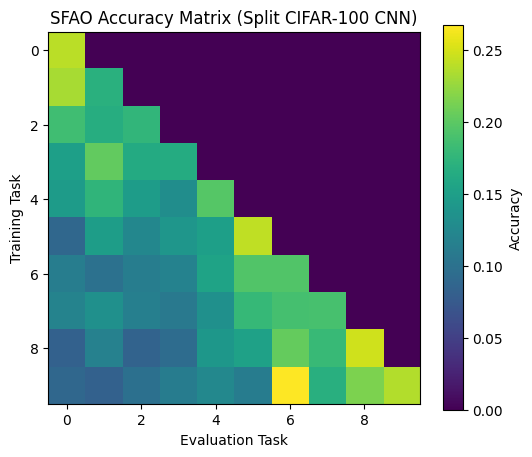

In [11]:
# === Cell: prepare CIFAR-100 tasks for SFAO (split or permuted) with CNN ===
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Hyperparameters ===
root = './data'
num_tasks = 10
num_classes = 100
classes_per_task = num_classes // num_tasks
batch_size = 24
download = True
mode = 'split'   # 'split' or 'permuted'
num_epochs = 2
learning_rate = 0.001

# CIFAR-100 mean/std for normalization
mean = torch.tensor([0.5071, 0.4867, 0.4408]).view(3, 1, 1)
std = torch.tensor([0.2675, 0.2565, 0.2761]).view(3, 1, 1)

# === Transforms ===
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()

# === Load datasets ===
train_ds = datasets.CIFAR100(root=root, train=True, download=download, transform=train_transform)
test_ds = datasets.CIFAR100(root=root, train=False, download=download, transform=test_transform)

# === Helper: extract subset tensors for a given set of class IDs ===
def extract_subset_tensors(dataset, class_list):
    targets = np.array(dataset.targets)
    mask = np.isin(targets, class_list)
    indices = np.nonzero(mask)[0].tolist()
    imgs, labs = [], []
    for i in indices:
        img, lbl = dataset[i]
        imgs.append(img)
        labs.append(lbl)
    return torch.stack(imgs), torch.tensor(labs, dtype=torch.long)

# === Prepare permutations if needed ===
permutations = []
if mode == 'permuted':
    rng = np.random.default_rng(42)
    for t in range(num_tasks):
        perm = rng.permutation(3 * 32 * 32).astype(np.int64)
        permutations.append(torch.tensor(perm, dtype=torch.long))

# === Build tasks ===
train_tasks, test_tasks = [], []
for t in range(num_tasks):
    cls_start = t * classes_per_task
    cls_end = cls_start + classes_per_task
    task_classes = list(range(cls_start, cls_end))

    x_train, y_train = extract_subset_tensors(train_ds, task_classes)
    x_test, y_test = extract_subset_tensors(test_ds, task_classes)

    # Apply permutation if required
    if mode == 'permuted':
        perm = permutations[t]
        N_train = x_train.shape[0]
        x_train = x_train.view(N_train, -1)[:, perm].view(N_train, 3, 32, 32)
        N_test = x_test.shape[0]
        x_test = x_test.view(N_test, -1)[:, perm].view(N_test, 3, 32, 32)

    # Normalize
    x_train = (x_train - mean) / std
    x_test = (x_test - mean) / std

    # Map labels to 0..(classes_per_task-1)
    class_map = {orig: i for i, orig in enumerate(task_classes)}
    y_train_mapped = torch.tensor([class_map[int(v)] for v in y_train])
    y_test_mapped = torch.tensor([class_map[int(v)] for v in y_test])

    # Store datasets (no flattening — CNN expects 3x32x32)
    train_tasks.append(TensorDataset(x_train, y_train_mapped))
    test_tasks.append(TensorDataset(x_test, y_test_mapped))

    print(f"Task {t}: classes {task_classes[0]}-{task_classes[-1]}, train={len(x_train)}, test={len(x_test)}")

print(f"Prepared {len(train_tasks)} tasks (mode={mode})")

# === CNN model ===
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x16x16
        x = self.pool(F.relu(self.conv2(x)))  # 64x8x8
        x = x.view(x.size(0), -1)             # flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)
        
# === SFAO class ===
# SFAO Implementation (Updated Methods Only)
class SFAO:
    def __init__(self, model, lr=0.001, device='cuda',
                 max_memory=200, cosine_threshold=0.80, discard_threshold=-1e-4, sample_size=750):
        self.model = model.to(device)
        self.lr = lr
        self.device = device
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.S = []  # stored gradient vectors
        self.max_memory = max_memory
        self.cosine_threshold = cosine_threshold
        self.discard_threshold = discard_threshold
        self.sample_size = sample_size

    # flatten gradient
    def _flatten_grad(self):
        return torch.cat([p.grad.view(-1) for p in self.model.parameters() if p.grad is not None])

    # assign gradient
    def _assign_grad(self, flat_grad):
        idx = 0
        for p in self.model.parameters():
            if p.grad is not None:
                numel = p.numel()
                p.grad.copy_(flat_grad[idx:idx+numel].view_as(p))
                idx += numel

    # project new gradient against memory
    def _project_grad(self, g):
        if len(self.S) == 0: return g
        # sample some stored gradients
        sampled = self.S if len(self.S)<=self.sample_size else [self.S[i] for i in torch.randperm(len(self.S))[:self.sample_size]]
        max_cos = 0.0
        for v in sampled:
            cos_sim = torch.dot(g, v)/(torch.norm(g)*torch.norm(v)+1e-12)
            max_cos = max(max_cos, abs(cos_sim.item()))
           #max_cos = max(max_cos, cos_sim.item())
        if max_cos > self.cosine_threshold:
            return g  # do not project
        if max_cos < self.discard_threshold:
            return None
        g_proj = g.clone()
        for v in sampled:
            proj = (torch.dot(g_proj, v)/torch.dot(v,v))*v
            g_proj -= proj
        # discard tiny projected gradients
        if torch.norm(g_proj) < self.discard_threshold:
            return None
        return g_proj

    # one training step
    def observe(self, x, y, criterion=nn.CrossEntropyLoss()):
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)
        self.optimizer.zero_grad()
        loss = criterion(self.model(x), y)
        loss.backward()

        g = self._flatten_grad()
        g_proj = self._project_grad(g)
        if g_proj is not None:
            self._assign_grad(g_proj)
            self.optimizer.step()
        return loss.item()

    # store task gradients
    def end_task(self, dataloader, criterion=nn.CrossEntropyLoss()):
        self.model.eval()
        for x, y in dataloader:
            x, y = x.to(self.device), y.to(self.device)
            self.model.zero_grad()
            loss = criterion(self.model(x), y)
            loss.backward()
            g = self._flatten_grad()
            norm_g = g / (torch.norm(g)+1e-10)
            if len(self.S) >= self.max_memory:
                self.S.pop(0)
            self.S.append(norm_g.detach().clone())

# === Training loop ===
sfao = SFAO(SimpleCNN(num_classes=classes_per_task), lr=learning_rate, device=device)
accuracy_matrix = np.zeros((num_tasks, num_tasks))

def evaluate_task(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

for task_id, train_dataset in enumerate(train_tasks):
    print(f"\n=== Training Task {task_id+1} ===")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x, y in tqdm(train_loader):
            epoch_loss += sfao.observe(x, y)
        print(f"Epoch {epoch+1}, Loss={epoch_loss/len(train_loader):.4f}")

    # Evaluate on all seen tasks
    for eval_id in range(task_id+1):
        test_loader = DataLoader(test_tasks[eval_id], batch_size=batch_size, shuffle=False)
        acc = evaluate_task(sfao.model, test_loader)
        accuracy_matrix[task_id, eval_id] = acc
        print(f"Accuracy on Task {eval_id+1}: {acc:.3f}")

    sfao.end_task(train_loader)

# === Metrics ===
ACC = accuracy_matrix[-1].mean()
F = np.mean([np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j] for j in range(num_tasks-1)]) if num_tasks>1 else 0.0
BWT = np.mean([accuracy_matrix[-1, j] - accuracy_matrix[j, j] for j in range(num_tasks-1)]) if num_tasks>1 else 0.0
FWT = np.mean([accuracy_matrix[i, i+1] for i in range(num_tasks-1)]) if num_tasks>1 else 0.0
num_params = sum(p.numel() for p in sfao.model.parameters())
mem_usage = len(sfao.S) * num_params * 4 / (1024**2)
PSM = 0.5*(1-F) + 0.5*max(FWT,0)

print("=== Metrics (Split CIFAR-100 CNN SFAO) ===")
print(f"ACC={ACC:.4f}, F={F:.4f}, BWT={BWT:.4f}, FWT={FWT:.4f}, Mem={mem_usage:.2f}MB, PSM={PSM:.4f}")

plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('SFAO Accuracy Matrix (Split CIFAR-100 CNN)')
plt.show()

Files already downloaded and verified
Files already downloaded and verified
Task 0: classes 0-1, train=10000, test=2000
Task 1: classes 2-3, train=10000, test=2000
Task 2: classes 4-5, train=10000, test=2000
Task 3: classes 6-7, train=10000, test=2000
Task 4: classes 8-9, train=10000, test=2000
Prepared 5 tasks (mode=split)

=== Training Task 1 ===


100%|██████████| 313/313 [00:00<00:00, 396.95it/s]


Epoch 1, Loss=0.6593


100%|██████████| 313/313 [00:01<00:00, 296.81it/s]


Epoch 2, Loss=0.5862
Accuracy on Task 1: 0.767

=== Training Task 2 ===


100%|██████████| 313/313 [00:09<00:00, 34.34it/s]


Epoch 1, Loss=0.7074


100%|██████████| 313/313 [00:09<00:00, 33.81it/s]


Epoch 2, Loss=0.6749
Accuracy on Task 1: 0.778
Accuracy on Task 2: 0.613

=== Training Task 3 ===


100%|██████████| 313/313 [00:08<00:00, 36.58it/s]


Epoch 1, Loss=0.6694


100%|██████████| 313/313 [00:08<00:00, 37.30it/s]


Epoch 2, Loss=0.6373
Accuracy on Task 1: 0.689
Accuracy on Task 2: 0.670
Accuracy on Task 3: 0.705

=== Training Task 4 ===


100%|██████████| 313/313 [00:08<00:00, 35.43it/s]


Epoch 1, Loss=0.6624


100%|██████████| 313/313 [00:08<00:00, 38.63it/s]


Epoch 2, Loss=0.6159
Accuracy on Task 1: 0.455
Accuracy on Task 2: 0.566
Accuracy on Task 3: 0.675
Accuracy on Task 4: 0.724

=== Training Task 5 ===


100%|██████████| 313/313 [00:09<00:00, 32.53it/s]


Epoch 1, Loss=0.6500


100%|██████████| 313/313 [00:09<00:00, 34.39it/s]


Epoch 2, Loss=0.5388
Accuracy on Task 1: 0.773
Accuracy on Task 2: 0.582
Accuracy on Task 3: 0.488
Accuracy on Task 4: 0.489
Accuracy on Task 5: 0.776
=== Metrics (Split CIFAR-10 CNN SFAO) ===
ACC=0.6219, F=0.1360, BWT=-0.1189, FWT=0.0000, Mem=815.38MB, PSM=0.4320


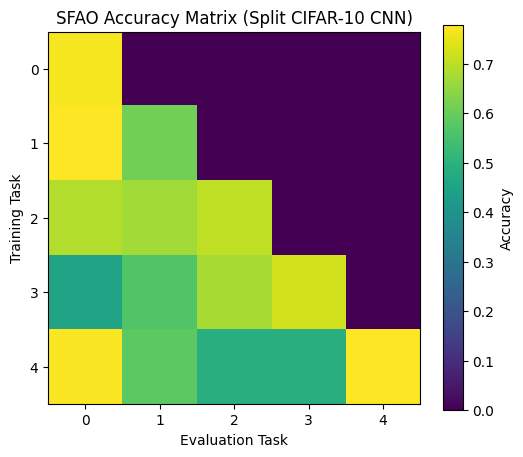

In [5]:
# Split CIFAR-10
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SFAO:
    def __init__(self, model, lr=0.001, device='cuda',
                 max_memory=200, cosine_threshold=0.80, discard_threshold=-1e-4, sample_size=750):
        self.model = model.to(device)
        self.lr = lr
        self.device = device
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.S = []  # stored gradient vectors
        self.max_memory = max_memory
        self.cosine_threshold = cosine_threshold
        self.discard_threshold = discard_threshold
        self.sample_size = sample_size

    # flatten gradient
    def _flatten_grad(self):
        return torch.cat([p.grad.view(-1) for p in self.model.parameters() if p.grad is not None])

    # assign gradient
    def _assign_grad(self, flat_grad):
        idx = 0
        for p in self.model.parameters():
            if p.grad is not None:
                numel = p.numel()
                p.grad.copy_(flat_grad[idx:idx+numel].view_as(p))
                idx += numel

    # project new gradient against memory
    def _project_grad(self, g):
        if len(self.S) == 0: return g
        # sample some stored gradients
        sampled = self.S if len(self.S)<=self.sample_size else [self.S[i] for i in torch.randperm(len(self.S))[:self.sample_size]]
        max_cos = 0.0
        for v in sampled:
            cos_sim = torch.dot(g, v)/(torch.norm(g)*torch.norm(v)+1e-12)
            max_cos = max(max_cos, abs(cos_sim.item()))
        if max_cos > self.cosine_threshold:
            return g  # do not project
        if max_cos < self.discard_threshold:
            return None
        g_proj = g.clone()
        for v in sampled:
            proj = (torch.dot(g_proj, v)/torch.dot(v,v))*v
            g_proj -= proj
        # discard tiny projected gradients
        if torch.norm(g_proj) < self.discard_threshold:
            return None
        return g_proj

    # one training step
    def observe(self, x, y, criterion=nn.CrossEntropyLoss()):
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)
        self.optimizer.zero_grad()
        loss = criterion(self.model(x), y)
        loss.backward()

        g = self._flatten_grad()
        g_proj = self._project_grad(g)
        if g_proj is not None:
            self._assign_grad(g_proj)
            self.optimizer.step()
        return loss.item()

    # store task gradients
    def end_task(self, dataloader, criterion=nn.CrossEntropyLoss()):
        self.model.eval()
        for x, y in dataloader:
            x, y = x.to(self.device), y.to(self.device)
            self.model.zero_grad()
            loss = criterion(self.model(x), y)
            loss.backward()
            g = self._flatten_grad()
            norm_g = g / (torch.norm(g)+1e-10)
            if len(self.S) >= self.max_memory:
                self.S.pop(0)
            self.S.append(norm_g.detach().clone())

# === Cell: prepare CIFAR-10 tasks for SFAO (split) with CNN ===
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Hyperparameters ===
root = './data'
num_tasks = 5            
num_classes = 10         
classes_per_task = num_classes // num_tasks   # = 2
batch_size = 32
download = True
mode = 'split'           # only "split"
num_epochs = 2
learning_rate = 0.001

# CIFAR-10 mean/std for normalization
mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)

# === Transforms ===
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()

# === Load datasets ===
train_ds = datasets.CIFAR10(root=root, train=True, download=download, transform=train_transform)
test_ds = datasets.CIFAR10(root=root, train=False, download=download, transform=test_transform)

# === Helper: extract subset tensors for a given set of class IDs ===
def extract_subset_tensors(dataset, class_list):
    targets = np.array(dataset.targets)
    mask = np.isin(targets, class_list)
    indices = np.nonzero(mask)[0].tolist()
    imgs, labs = [], []
    for i in indices:
        img, lbl = dataset[i]
        imgs.append(img)
        labs.append(lbl)
    return torch.stack(imgs), torch.tensor(labs, dtype=torch.long)

# === Build tasks ===
train_tasks, test_tasks = [], []
for t in range(num_tasks):
    cls_start = t * classes_per_task
    cls_end = cls_start + classes_per_task
    task_classes = list(range(cls_start, cls_end))

    x_train, y_train = extract_subset_tensors(train_ds, task_classes)
    x_test, y_test = extract_subset_tensors(test_ds, task_classes)

    # Normalize
    x_train = (x_train - mean) / std
    x_test = (x_test - mean) / std

    # Map labels to 0..(classes_per_task-1)
    class_map = {orig: i for i, orig in enumerate(task_classes)}
    y_train_mapped = torch.tensor([class_map[int(v)] for v in y_train])
    y_test_mapped = torch.tensor([class_map[int(v)] for v in y_test])

    # Store datasets (no flattening — CNN expects 3x32x32)
    train_tasks.append(TensorDataset(x_train, y_train_mapped))
    test_tasks.append(TensorDataset(x_test, y_test_mapped))

    print(f"Task {t}: classes {task_classes[0]}-{task_classes[-1]}, train={len(x_train)}, test={len(x_test)}")

print(f"Prepared {len(train_tasks)} tasks (mode={mode})")

# === CNN model ===
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):   # 2 classes per task
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x16x16
        x = self.pool(F.relu(self.conv2(x)))  # 64x8x8
        x = x.view(x.size(0), -1)             # flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# === Training loop ===
sfao = SFAO(SimpleCNN(num_classes=classes_per_task), lr=learning_rate, device=device)
accuracy_matrix = np.zeros((num_tasks, num_tasks))

def evaluate_task(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

for task_id, train_dataset in enumerate(train_tasks):
    print(f"\n=== Training Task {task_id+1} ===")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x, y in tqdm(train_loader):
            epoch_loss += sfao.observe(x, y)
        print(f"Epoch {epoch+1}, Loss={epoch_loss/len(train_loader):.4f}")

    # Evaluate on all seen tasks
    for eval_id in range(task_id+1):
        test_loader = DataLoader(test_tasks[eval_id], batch_size=batch_size, shuffle=False)
        acc = evaluate_task(sfao.model, test_loader)
        accuracy_matrix[task_id, eval_id] = acc
        print(f"Accuracy on Task {eval_id+1}: {acc:.3f}")

    sfao.end_task(train_loader)

# === Metrics ===
ACC = accuracy_matrix[-1].mean()
F = np.mean([np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j] for j in range(num_tasks-1)]) if num_tasks>1 else 0.0
BWT = np.mean([accuracy_matrix[-1, j] - accuracy_matrix[j, j] for j in range(num_tasks-1)]) if num_tasks>1 else 0.0
FWT = np.mean([accuracy_matrix[i, i+1] for i in range(num_tasks-1)]) if num_tasks>1 else 0.0
num_params = sum(p.numel() for p in sfao.model.parameters())
mem_usage = len(sfao.S) * num_params * 4 / (1024**2)
PSM = 0.5*(1-F) + 0.5*max(FWT,0)

print("=== Metrics (Split CIFAR-10 CNN SFAO) ===")
print(f"ACC={ACC:.4f}, F={F:.4f}, BWT={BWT:.4f}, FWT={FWT:.4f}, Mem={mem_usage:.2f}MB, PSM={PSM:.4f}")

plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('SFAO Accuracy Matrix (Split CIFAR-10 CNN)')
plt.show()

In [3]:
# To make the unzip command below work 
!apt-get update && apt-get install -y unzip

Get:1 http://archive.ubuntu.com/ubuntu jammy InRelease [270 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]      
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Get:6 http://archive.ubuntu.com/ubuntu jammy/restricted amd64 Packages [164 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy/main amd64 Packages [1792 kB]     
Get:8 http://archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [17.5 MB] 
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1929 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [266 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [5299 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1575

In [ ]:
# === Cell: Prepare Split TinyImageNet tasks for SFAO (CNN) ===
import os
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset
import random
from tqdm import tqdm

!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q /workspace/tiny-imagenet-200.zip -d /workspace/

In [ ]:
import os
print(os.listdir('/workspace/tiny-imagenet-200'))
print(os.listdir('/workspace/tiny-imagenet-200/train'))

In [4]:
# ===== Settings =====
root = '/workspace/tiny-imagenet-200' 
num_tasks = 10
num_classes = 200
classes_per_task = num_classes // num_tasks  # 20 per task
batch_size = 64
num_epochs = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ===== Transforms =====
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomCrop(64, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4802, 0.4481, 0.3975],
                         std=[0.2770, 0.2691, 0.2821])
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4802, 0.4481, 0.3975],
                         std=[0.2770, 0.2691, 0.2821])
])

# ===== Load datasets =====
train_ds = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
val_ds   = datasets.ImageFolder(os.path.join(root, 'val'), transform=test_transform)

# Map original class indices to sequential 0..199
class_to_idx = train_ds.class_to_idx
sorted_classes = sorted(class_to_idx.keys())
class_mapping = {class_to_idx[c]: i for i, c in enumerate(sorted_classes)}

train_labels = [class_mapping[label] for _, label in train_ds.samples]
val_labels   = [class_mapping[label] for _, label in val_ds.samples]

# Helper: get subset dataset for a class list
def subset_by_classes(dataset, labels, class_list):
    idxs = [i for i, lab in enumerate(labels) if lab in class_list]
    return Subset(dataset, idxs)

# ===== Create tasks =====
train_tasks, test_tasks = [], []
for t in range(num_tasks):
    cls_start = t * classes_per_task
    cls_end = cls_start + classes_per_task
    task_classes = list(range(cls_start, cls_end))
    train_tasks.append(subset_by_classes(train_ds, train_labels, task_classes))
    test_tasks.append(subset_by_classes(val_ds, val_labels, task_classes))
    print(f"Task {t}: Classes {cls_start}-{cls_end-1} | Train: {len(train_tasks[-1])}, Test: {len(test_tasks[-1])}")

# ===== Simple CNN for TinyImageNet =====
import torch.nn as nn
import torch.nn.functional as F

class TinyImageNetCNN(nn.Module):
    def __init__(self, num_outputs=20):  # default per task
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_outputs)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 64x32x32
        x = self.pool(F.relu(self.conv2(x)))  # 128x16x16
        x = self.pool(F.relu(self.conv3(x)))  # 256x8x8
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ===== SFAO setup =====
class SFAO:
    def __init__(self, model, lr=0.01, device='cuda'):
        self.model = model.to(device)
        self.lr = lr
        self.device = device
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.S = []  # Memory of gradient directions from previous tasks

    def _flatten_grad(self):
        return torch.cat([p.grad.view(-1) for p in self.model.parameters() if p.grad is not None])

    def _assign_grad(self, flat_grad):
        idx = 0
        for p in self.model.parameters():
            if p.grad is not None:
                numel = p.numel()
                p.grad.copy_(flat_grad[idx: idx+numel].view_as(p))
                idx += numel

    def _project_grad(self, g):
        if len(self.S) == 0:
            return g
        g_proj = g.clone()
        for v in self.S:
            proj = (torch.dot(g_proj, v) / torch.dot(v, v)) * v
            g_proj -= proj
        return g_proj

    # [Added method] Compute max cosine similarity between gradient g and sampled stored gradients
    def _cosine_similarity(self, sample, g):
        if len(sample) == 0:
            return 1.0
        max_sim = 0
        for v in sample:
            sim = torch.dot(g, v) / (torch.norm(g) * torch.norm(v))
            if sim > max_sim:
                max_sim = sim
        return max_sim

    # [Added method] Monte Carlo sample k gradients from stored memory without replacement
    def _monte_carlo(self, k):
        if len(self.S) <= k:
            return self.S
        else:
            return random.sample(self.S, k)

    # [Updated method] Selective projection based on cosine similarity threshold
    def observe(self, x, y, criterion=nn.CrossEntropyLoss(), threshold=0.80, sample_size=10):
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)
        self.optimizer.zero_grad()
        out = self.model(x)
        loss = criterion(out, y)
        loss.backward()

        g = self._flatten_grad()
        sample = self._monte_carlo(sample_size)
        max_sim = self._cosine_similarity(sample, g)

        if max_sim < threshold:
            g_orth = self._project_grad(g)
            self._assign_grad(g_orth)
        else:
            self._assign_grad(g)

        self.optimizer.step()
        return loss.item()

    def end_task(self, dataloader, criterion=nn.CrossEntropyLoss()):
        self.model.eval()
        for x, y in dataloader:
            x, y = x.to(self.device), y.to(self.device)
            self.model.zero_grad()
            out = self.model(x)
            loss = criterion(out, y)
            loss.backward()

            u = self._flatten_grad()
            u_proj = self._project_grad(u)
            norm_u_proj = u_proj / (u_proj.norm() + 1e-10)
            self.S.append(norm_u_proj.detach().clone())
            
accuracy_matrix = np.zeros((num_tasks, num_tasks))
sfao = SFAO(TinyImageNetCNN(classes_per_task), lr=0.01, device=device)

def evaluate_task(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

# ===== Training loop =====
for task_id, train_dataset in enumerate(train_tasks):
    print(f"\n=== Training Task {task_id+1} ===")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)
            epoch_loss += sfao.observe(x, y)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Evaluate on all seen tasks
    for eval_id in range(task_id+1):
        test_loader = DataLoader(test_tasks[eval_id], batch_size=batch_size, shuffle=False, num_workers=4)
        acc = evaluate_task(sfao.model, test_loader)
        accuracy_matrix[task_id, eval_id] = acc
        print(f"Accuracy on Task {eval_id+1}: {acc:.3f}")

    sfao.end_task(train_loader)

# ===== Metrics =====
ACC = accuracy_matrix[-1].mean()
F = np.mean([np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j] for j in range(num_tasks-1)]) if num_tasks>1 else 0.0
BWT = np.mean([accuracy_matrix[-1, j] - accuracy_matrix[j, j] for j in range(num_tasks-1)]) if num_tasks>1 else 0.0
FWT = np.mean([accuracy_matrix[i, i+1] for i in range(num_tasks-1)]) if num_tasks>1 else 0.0

num_params = sum(p.numel() for p in sfao.model.parameters())
mem_usage = len(sfao.S) * num_params * 4 / (1024**2)
PSM = 0.5*(1-F) + 0.5*max(FWT,0)

print("=== Metrics (Split TinyImageNet) ===")
print(f"ACC={ACC:.4f}, F={F:.4f}, BWT={BWT:.4f}, FWT={FWT:.4f}, Mem={mem_usage:.2f}MB, PSM={PSM:.4f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('SFAO Accuracy Matrix (Split TinyImageNet)')
plt.show()

NameError: name 'os' is not defined